In [5]:
import numpy as np
import pandas as pd
import torch
from torch.autograd import Variable
import torch.nn.functional as F
from torch import nn
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
ds = pd.read_csv('../../data/mnist.csv').values
print ds.shape

(42000, 785)


In [7]:
# Convert to one-hot encoding

# def one_hot(data, n_classes=None):
#     if n_classes is None:
#         n_classes = np.unique(data).shape[0]
#     oh = np.zeros((data.shape[0], n_classes))
    
#     for ix in range(oh.shape[0]):
#         oh[ix, data[ix]] = 1
#     return oh

In [8]:
# Data Preparation
X_train = ds[:10000, 1:].reshape((-1, 1, 28, 28)) / 255.0
y_train = ds[:10000, 0]

X_test = ds[5000:5100, 1:].reshape((-1, 1, 28, 28)) / 255.0
y_test = ds[5000:5100, 0]
# y_train = one_hot(y_train_labels, 10)

print X_train.shape, y_train.shape

(10000, 1, 28, 28) (10000,)


In [9]:
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         # input shape (1, 28, 28)
            nn.Conv2d(
                in_channels=1,              # input height
                out_channels=16,            # n_filters
                kernel_size=5,              # filter size
                stride=1,                   # filter movement/step
                padding=2,                  # if want same width and length of this image after con2d, padding=(kernel_size-1)/2 if stride=1
            ),                              # output shape (16, 28, 28)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(kernel_size=2),    # choose max value in 2x2 area, output shape (16, 14, 14)
        )
        
        self.conv2 = nn.Sequential(         # input shape (16, 14, 14)
            nn.Conv2d(16, 32, 5, 1, 2),     # output shape (32, 14, 14)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(2),                # output shape (32, 7, 7)
        )
        self.out = nn.Linear(32 * 7 * 7, 10)   # fully connected layer, output 10 classes
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)           # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        output = F.softmax(self.out(x))
        return output

In [10]:
cnn = CNN()
print cnn

cnn.cuda()

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)

In [113]:
# SGD needs more (like x100 more!) learning rate.
optimizer = torch.optim.SGD(cnn.parameters(), lr=0.1)   # optimize all cnn parameters
# TODO: Maybe add weight_decay parameter to the optimier?

loss_func = nn.CrossEntropyLoss()                       # the target label is not one-hotted

In [114]:
# cnn(torch.FloatTensor(X_train[9:10])).argmax()

In [115]:
def make_batch(train, labels, batch_size=10, gpu=True):
    start = 0
    stop = start + batch_size
    while start < train.shape[0]:
        if gpu:
            yield Variable(torch.FloatTensor(train[start:stop]), requires_grad=True).cuda(), Variable(torch.LongTensor(labels[start:stop])).cuda()
        else:
            yield Variable(torch.FloatTensor(train[start:stop]), requires_grad=True).cuda(), Variable(torch.LongTensor(labels[start:stop])).cuda()
        start = stop
        stop = start + batch_size

In [116]:
# for s, (ix, iy) in enumerate(make_batch(X_train, y_train, batch_size=100)):
#     print s, ix.shape, iy.shape

In [119]:

for epoch in range(10):
    for step, (b_x, b_y) in enumerate(make_batch(X_train, y_train, 512)):   # gives batch data, normalize x when iterate train_loader
        # print step,
        output = cnn(b_x)               # cnn output
        # print output.size(), output.sum(dim=0)
        loss = loss_func(output, b_y)   # cross entropy loss
        optimizer.zero_grad()           # clear gradients for this training step
        loss.backward()                 # backpropagation, compute gradients
        
        # for params in cnn.parameters():
        #     print params.grad.cpu().data.sum() # Y U no train!!!
        optimizer.step()                # apply gradients

        if step % 50 == 0:
            test_output = cnn(torch.FloatTensor(X_test).cuda())
            outs = test_output.cpu().data.numpy().argmax(axis=1)
            acc = (outs == y_test).sum()*100.0 / test_output.shape[0]
            # pred_y = torch.max(test_output, 1)[1].data.squeeze().numpy()
            # accuracy = float((pred_y == test_y.data.numpy()).astype(int).sum()) / float(test_y.size(0))
            print('Epoch: ', epoch, '| Step: ', step, '| Acc: ', acc)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


tensor(2.3027, device='cuda:0')
('Epoch: ', 0, '| Step: ', 0, '| Acc: ', 8.0)
tensor(2.3026, device='cuda:0')
tensor(2.3026, device='cuda:0')
tensor(2.3027, device='cuda:0')
tensor(2.3025, device='cuda:0')
tensor(2.3028, device='cuda:0')
tensor(2.3023, device='cuda:0')
tensor(2.3026, device='cuda:0')
tensor(2.3026, device='cuda:0')
tensor(2.3026, device='cuda:0')
tensor(2.3027, device='cuda:0')
tensor(2.3026, device='cuda:0')
tensor(2.3028, device='cuda:0')
tensor(2.3026, device='cuda:0')
tensor(2.3029, device='cuda:0')
tensor(2.3028, device='cuda:0')
tensor(2.3025, device='cuda:0')
tensor(2.3027, device='cuda:0')
tensor(2.3025, device='cuda:0')
tensor(2.3027, device='cuda:0')
tensor(2.3027, device='cuda:0')
('Epoch: ', 1, '| Step: ', 0, '| Acc: ', 7.0)
tensor(2.3025, device='cuda:0')
tensor(2.3026, device='cuda:0')
tensor(2.3027, device='cuda:0')
tensor(2.3025, device='cuda:0')
tensor(2.3028, device='cuda:0')
tensor(2.3023, device='cuda:0')
tensor(2.3026, device='cuda:0')
tensor(2.302

In [106]:
cnn.cpu()

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)

In [107]:
outs = cnn(torch.FloatTensor(X_train))

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [108]:
(outs.data.numpy().argmax(axis=1) == y_train).sum()*100 / float(y_train.shape[0])

95.16

# Viz

In [109]:
print cnn.state_dict().keys()

['conv1.0.weight', 'conv1.0.bias', 'conv2.0.weight', 'conv2.0.bias', 'out.weight', 'out.bias']


In [110]:
conv_01 = cnn.state_dict()['conv1.0.weight']
print conv_01.shape

torch.Size([16, 1, 5, 5])


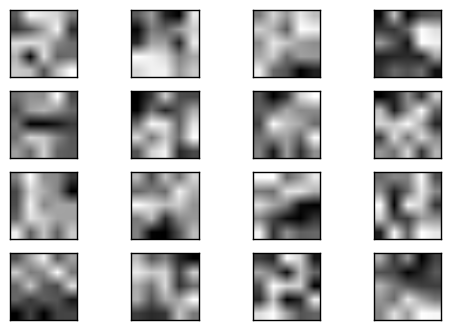

In [111]:
plt.figure(0)
for ix in range(conv_01.shape[0]):
    plt.subplot(4, 4, ix+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(conv_01[ix].reshape((5, 5)), cmap='gray')
plt.show()
